# CASA0013: Foundations of Spatial Data Science

### Student Name : Jeonghwa Kang

### Student ID : 21044456

### Github(Dataset) : https://github.com/henry-kang-7/CASA0013.git

# Reproducible Analysis

In [1]:
from sklearn.cluster import KMeans, OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
import math
%matplotlib inline
pts = PowerTransformer()

# we are selecing columns that are needed only.
cols = ['id', 'room_type', 'price', 'reviews_per_month', 'neighbourhood',
        'calculated_host_listings_count', 'availability_365', 'minimum_nights',
        'last_review', 'latitude', 'longitude']

# reading csv file 'listings.csv' with specified columns above.
df = pd.read_csv('listings.csv', low_memory=True, usecols=cols)

# shape[0] = no. of rows, shape[1] = no. of columns.
print(f"Data frame is {df.shape[0]} x {df.shape[1]}")

# pick any 6 samples to confirm.
df.sample(6, random_state=1)

# drop rows where reviews_per_month and last_review is NA.
df.drop(index=df[((df.reviews_per_month.isna()) | (df.last_review.isna()))].index, axis=0, inplace=True)
print(df.shape)

# estimated booking nights per month = (No. of reviews per month / review rate of 50%)
df['monthly_estimated_booking'] = df.reviews_per_month / 0.5
df['yearly_estimated_booking'] = df.monthly_estimated_booking * 12

# monthly occupancy = average length of stay(4.6 nights) * (No. of reviews per month / review rate of 50%)
df['monthly_occupancy'] = df.monthly_estimated_booking * 4.6
df['yearly_occupancy'] = df.monthly_occupancy * 12

# yearly income = monthly occupancy rate * price * 12
df['yearly_income'] = df.monthly_occupancy * df.price * 12

# change the data type of last_review column to actual datetime object.
df['last_review'] = pd.to_datetime(df['last_review'])
df['room_type'] = df['room_type'].astype(str)

# last review posted within 6 months & room types are 'Entire home/apt' or 'Private room' only.
# availablity above 90 days per year or yearly estimated booking is over 90 days or an individual host has multiple listings.
df_illegal = df[((df.last_review > '2021-06-01') & ((df.room_type == 'Entire home/apt') | (df.room_type == 'Private room'))) &
                ((df.availability_365 > 90) | (df.yearly_occupancy > 90) | (df.calculated_host_listings_count > 1))]
df_illegal.sample(6, random_state=1)

# we now have illegal listings but what let us group the listings by each boroughs in London.
df_illegal_boroughs = df_illegal.groupby(['neighbourhood'])

Data frame is 67903 x 11
(48875, 11)


Text(0.5, 0.98, 'No. of Boroughs vs. Mean Yearly Income')

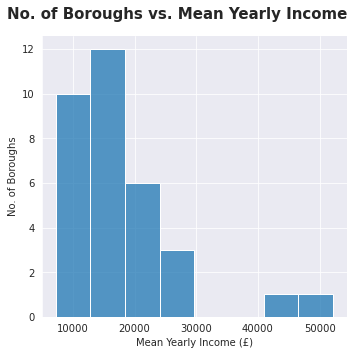

In [2]:
# draw a histogram of yearly income(mean) of each boroughs in London.
sns.set_style('darkgrid')
ax = sns.displot(df_illegal_boroughs.yearly_income.mean())
ax.set(xlabel='Mean Yearly Income (£)', ylabel='No. of Boroughs')
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().suptitle('No. of Boroughs vs. Mean Yearly Income', fontsize=15, fontweight='bold')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


(500648.735, 564876.965, 153596.645, 203188.055)

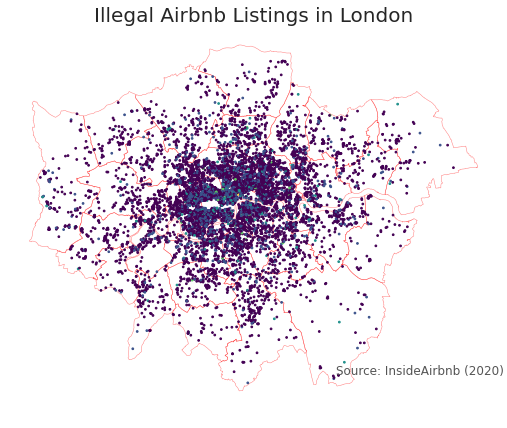

In [3]:
# loading census shape. The main one is the London borough and the following two census are water and vegetations.
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

# Since there are longitude and latitude columns in illegal listings dataset, we are converting it into geo-dataframe.
gdf = gpd.GeoDataFrame(df_illegal, geometry=gpd.points_from_xy(df_illegal.longitude, df_illegal.latitude, crs = 'epsg:4326'))
gdf = gdf.to_crs(27700)

# plotting borough census shape as well as geo-dataframe(illegal listings)
ax = boros.plot(figsize=(10, 7), edgecolor='red', facecolor='none', linewidth=0.5, alpha=0.5)
gdf.plot(markersize=3, column='yearly_income', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax = ax)
ax.set_title('Illegal Airbnb Listings in London', fontdict={'fontsize':'20', 'fontweight':'3'})
a = ax.annotate('Source: InsideAirbnb (2020)',
                xy=(0.7, 0.1), xycoords='figure fraction',
                horizontalalignment='right', verticalalignment='bottom',
                fontsize=12, fontweight=4, color='#555555')
ax.axis('off')
#ax.set_xlim([510000, 550000])
#ax.set_ylim([165000, 195000])

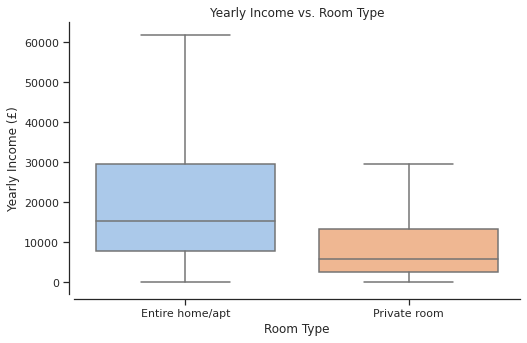

In [4]:
# boxplot x being room_type while y being yearly income.
# let us see the general distribution of yearly income of different room types.
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
f, ax = plt.subplots(figsize=(8, 5))
ax = sns.boxplot(y=gdf.yearly_income, x=gdf.room_type, showfliers=False)
ax.set_title('Yearly Income vs. Room Type')
ax.set_ylabel('Yearly Income (£)')
ax.set_xlabel('Room Type')
sns.despine(offset=5)

In [5]:
# conducting a simple description analysis. 
# this analysis table illustrates count, sum, mean etc. information of illegal listings by different boroughs and room types.
df_illegal_desc = df_illegal.groupby(['neighbourhood', 'room_type']).agg({'yearly_income':['count', 'sum', 'mean', 'median', 'std',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]}).reset_index()
df_illegal_desc.columns = df_illegal_desc.columns.droplevel(0)
cols = df_illegal_desc.columns.values
cols[0] = 'neighbourhood'
cols[1] = 'room_type'
cols[-2] = 'Q1'
cols[-1] = 'Q3'
df_illegal_desc.columns = cols
df_illegal_desc.sort_values(by='mean', ascending=False).head(10)
df_illegal_desc

,neighbourhood,room_type,count,sum,mean,median,std,Q1,Q3
0,Barking and Dagenham,Entire home/apt,35,7.836612e+05,22390.318629,12403.440,29054.368731,5365.440,25016.640
1,Barking and Dagenham,Private room,31,1.171697e+05,3779.668645,3394.800,3382.289874,1468.320,5049.144
2,Barnet,Entire home/apt,116,2.048593e+06,17660.288276,10358.832,21077.530480,4729.536,21914.400
3,Barnet,Private room,89,6.934610e+05,7791.697079,2489.520,21120.368894,1132.704,4716.288
4,Bexley,Entire home/apt,17,2.637666e+05,15515.680941,6670.368,19248.919728,5023.200,10588.464
...,...,...,...,...,...,...,...,...,...
61,Waltham Forest,Private room,73,4.292440e+05,5880.055233,3825.360,6376.600673,1761.984,7116.384
62,Wandsworth,Entire home/apt,229,5.809471e+06,25368.869031,17332.800,34284.724463,8755.824,30691.200
63,Wandsworth,Private room,165,1.939076e+06,11751.972945,6089.664,28776.021995,2852.736,11764.224
64,Westminster,Entire home/apt,1107,4.427120e+07,39992.049951,21143.808,84802.944882,10882.680,40426.272


Text(0.5, 1.0, 'Mean Yearly Income vs. Room Type')

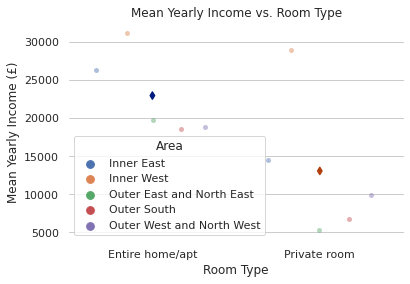

In [6]:
# to go one step further, I have divided and categorized the boroughs of London into Innter and Outer London.
# also, their direction of locations have been specified with East, West, North and South.
mapping = {}
for b in ['Enfield', 'Waltham Forest', 'Redbridge', 'Barking and Dagenham', 'Havering', 'Greenwich', 'Bexley']:
    mapping[b] = 'Outer East and North East'
for b in ['Haringey', 'Islington', 'Hackney', 'Tower Hamlets', 'Newham', 'Lambeth', 'Southwark', 'Lewisham']:
    mapping[b] = 'Inner East'
for b in ['Bromley', 'Croydon', 'Sutton', 'Merton', 'Kingston upon Thames']:
    mapping[b] = 'Outer South'
for b in ['Wandsworth', 'Kensington and Chelsea', 'Hammersmith and Fulham', 'Westminster', 'Camden']:
    mapping[b] = 'Inner West'
for b in ['Richmond upon Thames', 'Hounslow', 'Ealing', 'Hillingdon', 'Brent', 'Harrow', 'Barnet', 'City of London']:
    mapping[b] = 'Outer West and North West'

# similar to what we did above, we are now calculating the mean and median of yearly income of different locations of London.
df_illegal_2 = df_illegal.set_index('neighbourhood').groupby([mapping, 'room_type']).agg({'yearly_income':['mean', 'median']}).reset_index()
df_illegal_2.columns = df_illegal_2.columns.droplevel(0)
cols = df_illegal_2.columns.values
cols[0] = 'area'
cols[1] = 'room_type'
df_illegal_2.columns = cols
df_illegal_2.sort_values(by='mean', ascending=False).head(10)

# plotting strip plot for visualisation. X axis conveys the two room types, Enitre home/apt and private room. y axis is the yearly income(mean)
# for the value of hue, it is different categorical areas of London. This is the mapping which we have constructed as in dict type.
sns.set_theme(style="whitegrid")
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)
g = sns.stripplot(x="room_type", y="mean", hue="area", data=df_illegal_2, dodge=True, alpha=.45, zorder=1)
g.legend_.set_title('Area')
# Show the mean of means
sns.pointplot(x="room_type", y="mean",
              data=df_illegal_2.groupby('room_type').agg('mean').reset_index(),
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)
g.set_ylabel('Mean Yearly Income (£)')
g.set_xlabel('Room Type')
g.set_title("Mean Yearly Income vs. Room Type")

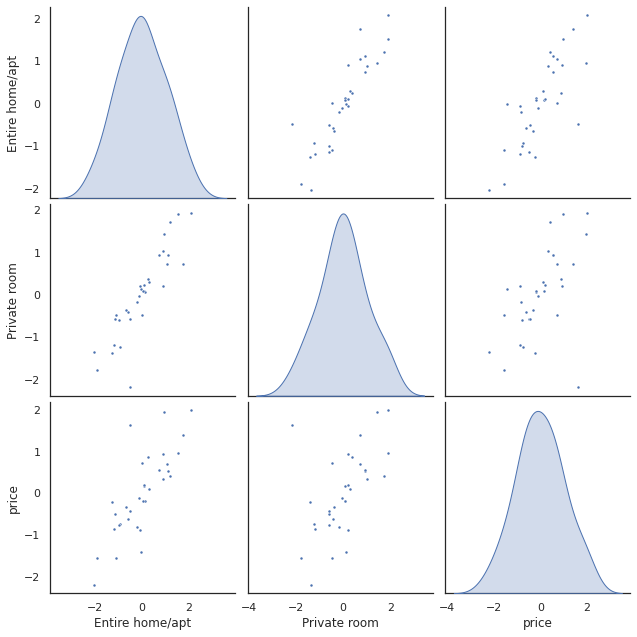

In [7]:
# using geo-dataframe, we first group by boroughs of London and room type and count each of them.
mlgc = gdf.groupby(['neighbourhood','room_type'])['price'].agg(Count='count').reset_index()

# using geo-dataframe, we group by boroughs of London find price mean of each boroughs.
mlgp = gdf.groupby('neighbourhood')['price'].agg('mean').reset_index()

mlgc = mlgc.pivot(index='neighbourhood', columns=['room_type'], values=['Count']).reset_index()
mlgc.columns = ['neighbourhood','Entire home/apt','Private room']

# merge the two tables by 'neighbourhood' column.
mlg = pd.merge(mlgc, mlgp, on='neighbourhood')
mlg = mlg.fillna(0).set_index('neighbourhood')

for c in mlg.columns.values:
    mlg[c] = pts.fit_transform(mlg[c].values.reshape(-1,1))

# this is an important section. This plot visualises relationships between each variable we have.
# relationships between Enitre home/apt vs. Private room, Entire home/apt vs. Price and so on.
sns.set(style="white")
sns.pairplot(mlg, markers=".", height=3, diag_kind='kde')

[0 2 0 2 0 1 2 2 2 0 1 1 1 2 0 0 2 2 1 1 0 1 2 2 2 2 2 1 0 1 2 1 1]


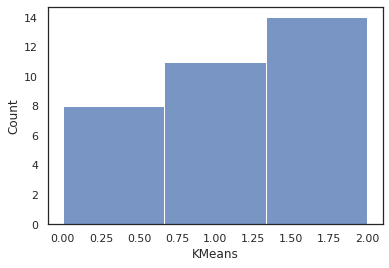

In [8]:
# preparation for conducting Kmeans analysis.
c_nm = 'KMeans' # assigning clustering name
k_pref = 3 # number of clusters

# remember, our 'mlg' table contains grouped listings by each borough.
# it contains mean price and total count of entire home/apt as well as private room.
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(mlg)
print(kmeans.labels_)

# adding it to the data frame our cluster values.
mlg[c_nm] = pd.Series(kmeans.labels_, index=mlg.index)
mlg

# how are the clusters distributed?
ax = sns.histplot(data=mlg, x=c_nm, bins=k_pref)

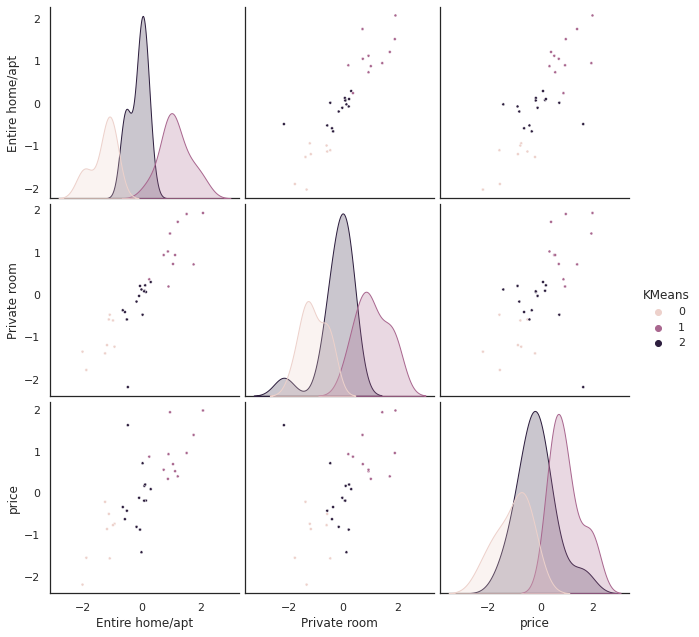

In [9]:
# similar to the pair plot we just conducted above but this time,
# we are specifying the columns as well as assigning the hue value.
sns.set(style="white")
sns.pairplot(mlg, vars=['Entire home/apt', 'Private room', 'price'], hue=c_nm, markers=".", height=3, diag_kind='kde')

<AxesSubplot:>

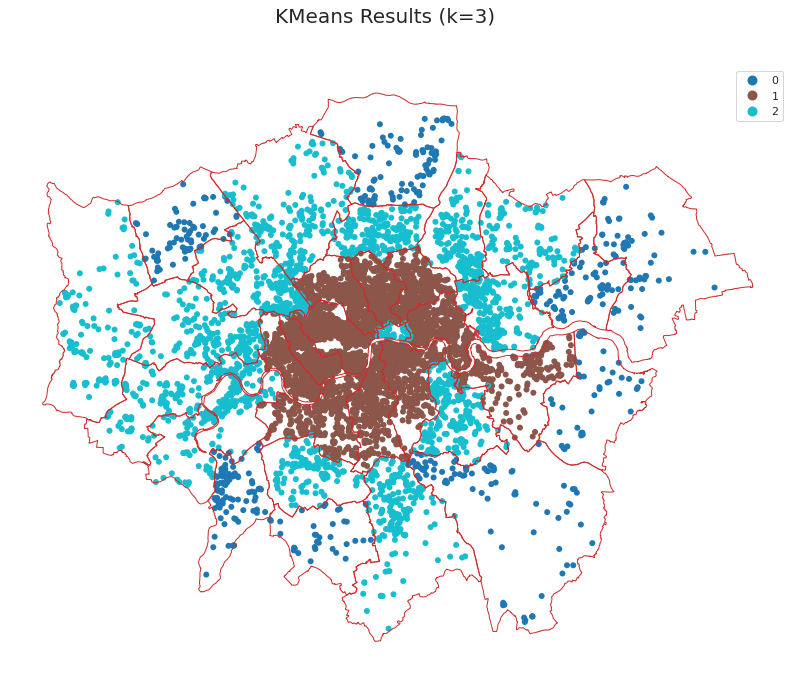

In [10]:
# adding the cluster values to our geo-dataframe as well.
# all the listings in each borough share the same value of clusters.
# this is because we want to see how the listings in different boroughs are linked together if there is.
gdf_mlg_rs = pd.merge(gdf, mlg, on = 'neighbourhood')

def plt_ldn(b):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axis('off')
    return fig, ax

fig, ax = plt_ldn(boros)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
gdf_mlg_rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True)

.............
Largest silhouette score was 0.5414 for k=4


Text(0.5, 0.98, 'Average Silhouette Scores')

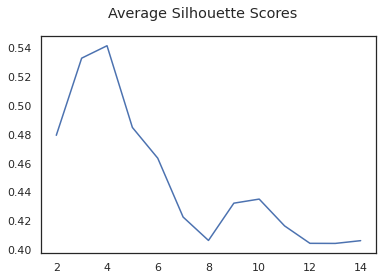

In [11]:
# preparing for sillouette analysis.
x = []
y = []

for k in range(2,15):
    
    # using mlg table, we will conduct sillouette analysis to see where the listings are clustered.
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(mlg)
    
    # calculate the overall silhouette score here.
    silhouette_avg = silhouette_score(mlg, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores")

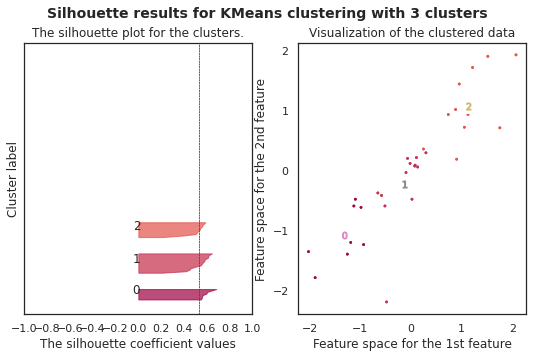

In [12]:
# number of clusters
k_pref=3

# calcaulting the clustering based on the mlg table.
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(mlg)
    
# calculating the overall silhouette score
silhouette_avg = silhouette_score(mlg, kmeans.labels_)

# Calculating the silhouette values
sample_silhouette_values = silhouette_samples(mlg, kmeans.labels_)
    
# creating a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# the 1st subplot is the silhouette plot
# the silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0])
    
# the (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, mlg.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# for each of the clusters...
for i in range(k_pref):
    # aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # the vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(mlg[mlg.columns[0]], mlg[mlg.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # labeling the clusters
    centers = kmeans.cluster_centers_
    
    # draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')
plt.show()

Text(0.5, 0.98, 'Nearest Neighbour Distances')

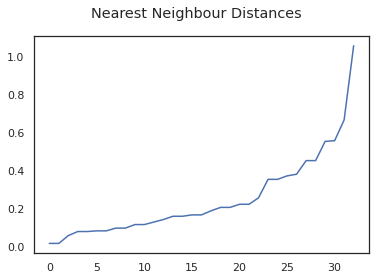

In [13]:
# extracting two columns from the mlg table.
mlg2 = mlg.loc[:,['Entire home/apt','Private room']]
mlg2.head()

# conducting the nearest neighbours analysis.
nbrs = NearestNeighbors(n_neighbors=4).fit(mlg2)
distances, indices = nbrs.kneighbors(mlg2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.gcf().suptitle("Nearest Neighbour Distances")

<AxesSubplot:>

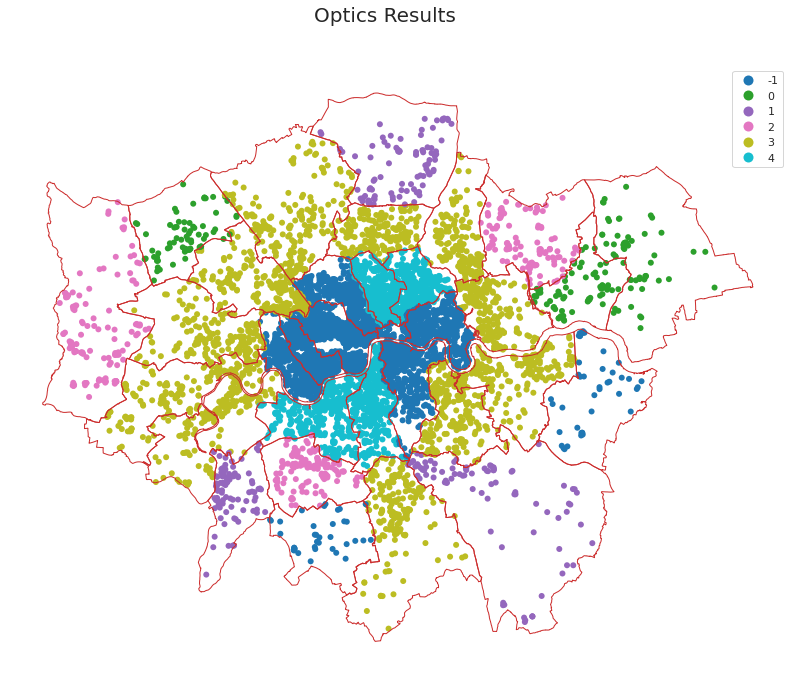

In [14]:
# conducting Optics analysis
c_nm = 'Optics'

e = 0.6

# run the clustering for the mlg2 dataset.
opt = OPTICS(min_samples=len(mlg2.columns)+1, max_eps=math.ceil(e * 100)/25, n_jobs=-1).fit(mlg2)

# create new column and assign the values of clusters
mlg2[c_nm] = pd.Series(opt.labels_, index=mlg2.index, name=c_nm)
gdf_mlg_rs = pd.merge(gdf, mlg2, on='neighbourhood')

# plot the results we have.
fig, ax = plt_ldn(boros)
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)
gdf_mlg_rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, legend=True, categorical=True)